In [13]:
## Imports

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor
from gwpy.signal import filter_design
from gwpy.timeseries import TimeSeries
from tqdm.notebook import tqdm

# Definitions

In [87]:
## Animator and plotting classes

def get_rolling_windows(data, window, offset=0):
    if window - offset - 1 < 0:
        raise ValueError("window must be greater than offset")
    data_length = data.size
    if offset > 0:
        data = np.insert(data, 0, np.full(offset, data[0]))
    if window - offset - 1 > 0:
        data = np.append(data, np.full(window-offset-1, data[-1]))
    frames = [data[i:data_length+i] for i in range(window)]
    windows = np.stack(frames, axis=-1)
    return windows


def check_time_data(times, data):
    if times.size != data.size:
        raise ValueError('times and data must be the same size')


def plot_lof_topology(times, data, lofs, crit_lof, axs=None):
    check_time_data(times, data)
    
    if axs is None or len(axs) != 2:
        _, axs = plt.subplots(2, 1)
    
    is_outlier = lofs > crit_lof
    lof_detections = np.stack((times[is_outlier], lofs[is_outlier]), axis=-1)
    
    plots = [
        # time_series
        axs[0].plot(times, data, 'c-', zorder=1)[0],
        # time_series_outliers
        axs[0].scatter(
            times[is_outlier], data[is_outlier], marker='+', facecolors='k', zorder=2),
        # lofs
        axs[1].plot(times, lofs, 'c-', zorder=1)[0],
        # lofs_outliers
        axs[1].scatter(
            times[is_outlier], lofs[is_outlier], marker='+', facecolors='k', zorder=2)
    ]
    return plots

def plot_lof_time_series(times, data, window=20, xlim=None):
    check_time_data(times, data)
    fig, axs = plt.subplots(2, 1, figsize=(8,6), sharex=True)
    fig.suptitle('LOF Topology of Time Series')
    axs[0].set_ylabel('Time series values')
    axs[1].set_ylabel('LOF')
    axs[1].set_xlabel('Time')
    
    if xlim is not None:
        axs[1].set_xlim(*xlim)
    
    fig.tight_layout()

    windows = get_rolling_windows(hdata, window, offset=int(window/2))
    clf = LocalOutlierFactor()
    clf.fit_predict(windows)
    lofs = -clf.negative_outlier_factor_
    mean_lof = np.mean(lofs)
    lof_std = np.std(lofs)
    crit_lof = 3*lof_std + mean_lof
    
    plot_lof_topology(times, data, lofs, crit_lof, axs)


class LOFMaxStdWindowAnimation:
    def __init__(
        self, data,
        times=None, n_range=range(4,30), n_neighbors=20,
        xlim=None, interval=500):
        
        if len(data.shape) != 1:
            raise ValueError("Input must be 1D time series")
        self.data = data
        if times is None:
            times = np.arange(0,data.size)
        self.times = times
        self.n_range = list(n_range)
        self.n_neighbors = n_neighbors
        self.fig, self.axs = plt.subplots(3, 1, figsize=(8,12))
        self.xlim = xlim
        self.anim = animation.FuncAnimation(
            self.fig, self.animate,
            init_func=self.setup_plot,
            frames=tqdm(n_range),
            interval=interval,
            blit=True
        )

    def setup_plot(self):
        blank = np.zeros(0)
        self.plots = [
            self.axs[0].plot(blank, blank)[0],
            self.axs[0].plot(blank, blank)[0],
            *plot_lof_topology(blank, blank, blank, 0, self.axs[1:])
        ]
            
        self.axs[0].set_title('Peak LOF deviation from mean per windowing size')
        self.axs[0].set_ylabel('Peak LOF deviation ($\sigma$)')
        self.axs[0].set_xlabel('Window size')
        self.axs[1].set_title('LOF Detections in Time Series')
        self.axs[1].set_ylabel('time series')
        
        if self.xlim is not None:
            self.axs[1].set_xlim(*self.xlim)
            self.axs[2].set_xlim(*self.xlim)
        
        self.axs[1].get_shared_x_axes().join(self.axs[1], self.axs[2])
        self.axs[1].set_xticklabels([])
        self.axs[2].set_xlabel('times')
        self.axs[2].set_ylabel('LOF')
        self.fig.tight_layout()
        
        self.max_lofs = []
        self.curr_range = []
        
        return self.plots

    def animate(self, n):
        windows = get_rolling_windows(self.data, n, offset=int(n/2))
        clf = LocalOutlierFactor(n_neighbors=self.n_neighbors)
        clf.fit_predict(windows)
        lofs = -clf.negative_outlier_factor_
        mean_lof = np.mean(lofs)
        lof_std = np.std(lofs)
        crit_lof = 3*lof_std + mean_lof
        is_outlier = lofs > crit_lof
        
        max_dev = (np.max(lofs) - mean_lof) / lof_std
        self.max_lofs.append(max_dev)
        self.curr_range.append(n)
        new_outliers = np.stack((self.times[is_outlier], self.data[is_outlier]), axis=-1)
        new_lof_detections = np.stack((self.times[is_outlier], lofs[is_outlier]), axis=-1)
        
        # Clear previous frame
        for plot in self.plots:
            plot.remove()
        # Generate new plots
        self.plots = [
            self.axs[0].plot(self.curr_range, self.max_lofs, 'c-', zorder=1)[0],
            self.axs[0].plot(n, max_dev, 'ko', zorder=2)[0],
            *plot_lof_topology(self.times, self.data, lofs, crit_lof, self.axs[1:])
        ]
        
        return self.plots
    
    def save(self, *args, **kwargs):
        return self.anim.save(*args, **kwargs)
    
    def show(self, *args, **kwargs):
        return HTML(self.anim.to_html5_video(*args, **kwargs))

In [69]:
## Data fetching and pre-processing functions

def get_processed_event(detector, gps_time, length=10, offset=0, edges=1, downsample=1):
    ts = get_raw_event(detector, gps_time, length, offset, edges)
    border = int(edges/ts.dt.value)
    ts = preprocess_timeseries(ts)[border:-border]
    return ts[::downsample]


def get_raw_event(detector, gps_time, length=10, offset=0, edges=1):
    bracket = edges + length/2
    t0 = gps_time - bracket + offset
    t1 = gps_time + bracket + offset
    return TimeSeries.fetch_open_data(detector, t0, t1, cache=True)
    

def preprocess_timeseries(ts):
    # Whiten
    ts = ts.whiten()
    # Bandpass
    ts = ts.bandpass(30, 400)
    
    return ts

In [92]:
## Data sources

DET = 'L1'

SCATTERED_LIGHT = [
    1253331031.313,
    1253362400.688,
    1245551779.625,
    1242316342.688,
    1250543149.438
]

BLIP = [
    1241313885.077,
    1241059759.294,
    1244759854.760,
    1248201703.322,
    1246580860.546
]

TOMTE = [
    1249463266.059,
    1243933155.996,
    1253921604.105,
    1244937658.590,
    1252535668.965   
]

ALL = [SCATTERED_LIGHT, BLIP, TOMTE]

# Playground

In [89]:
hdata = get_processed_event(DET, BLIP[0], length=4, downsample=1)

#fn = 'data/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5'
#ts = TimeSeries.read(fn,format='hdf5.losc')[::100]
#ts = ts[int(11*ts.size/22):int(13*ts.size/22)]
#ts = ts[int(ts.size/4):int(ts.size/2)]
#hdata = ts

NOW PLOTTING EVENTS OF CLASS 0


  0%|          | 0/5 [00:00<?, ?it/s]

NOW PLOTTING EVENTS OF CLASS 1


  0%|          | 0/5 [00:00<?, ?it/s]

NOW PLOTTING EVENTS OF CLASS 2


  0%|          | 0/5 [00:00<?, ?it/s]

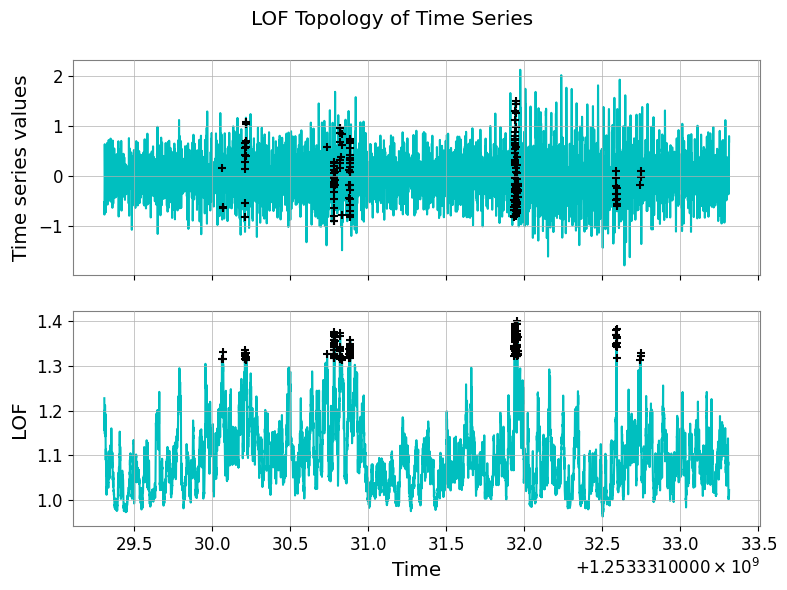

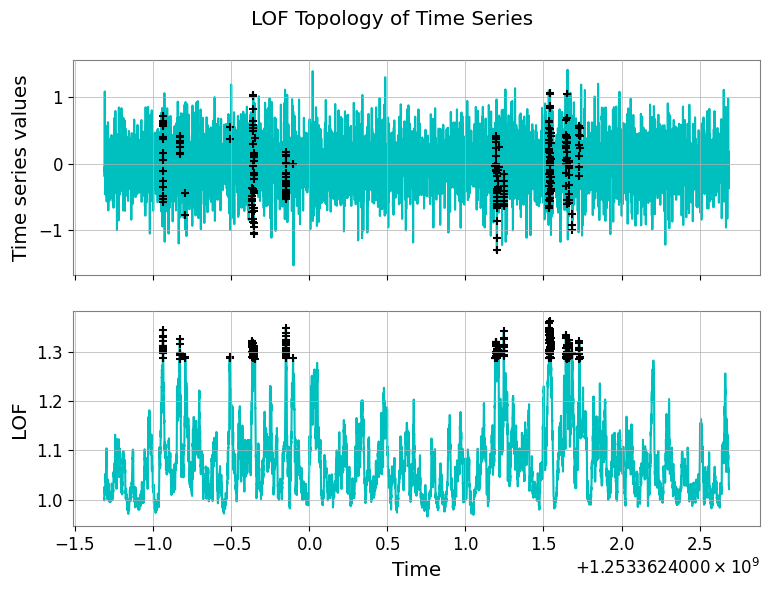

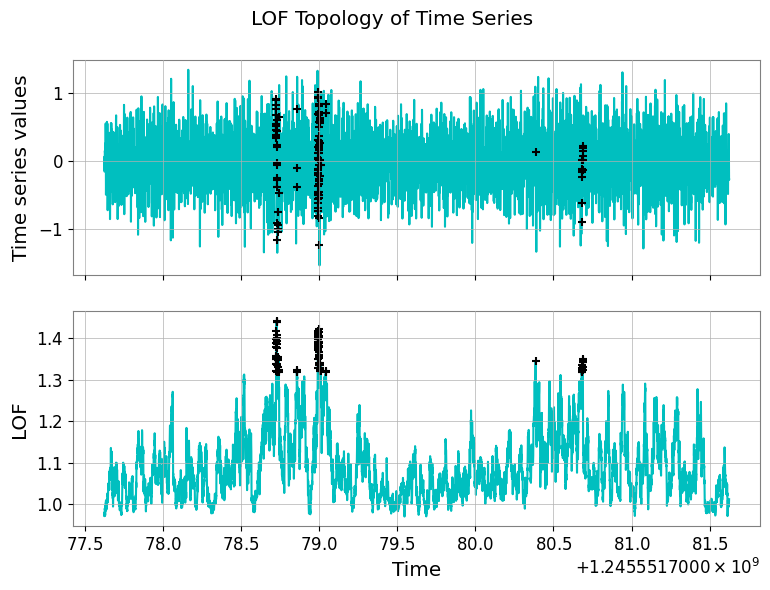

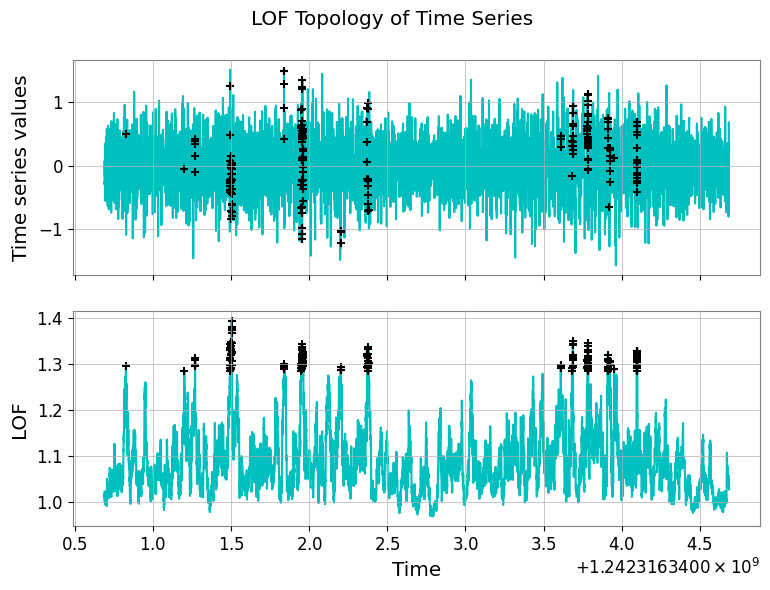

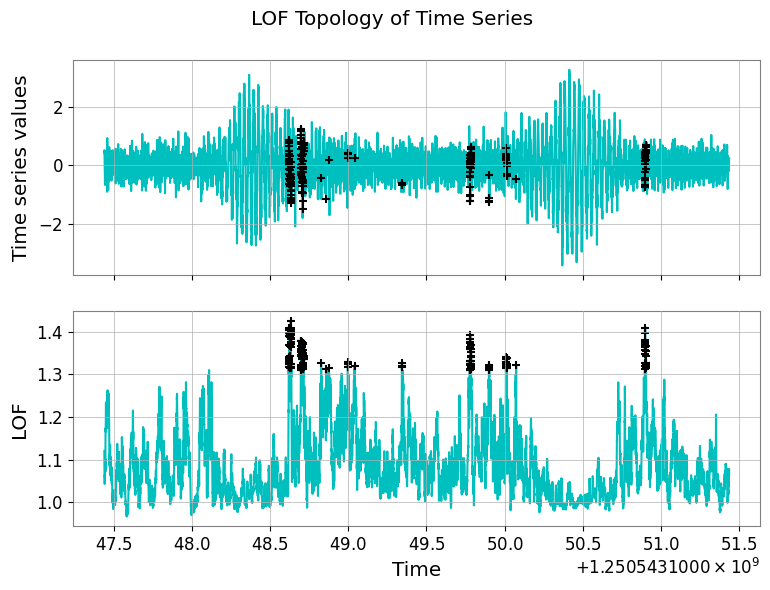

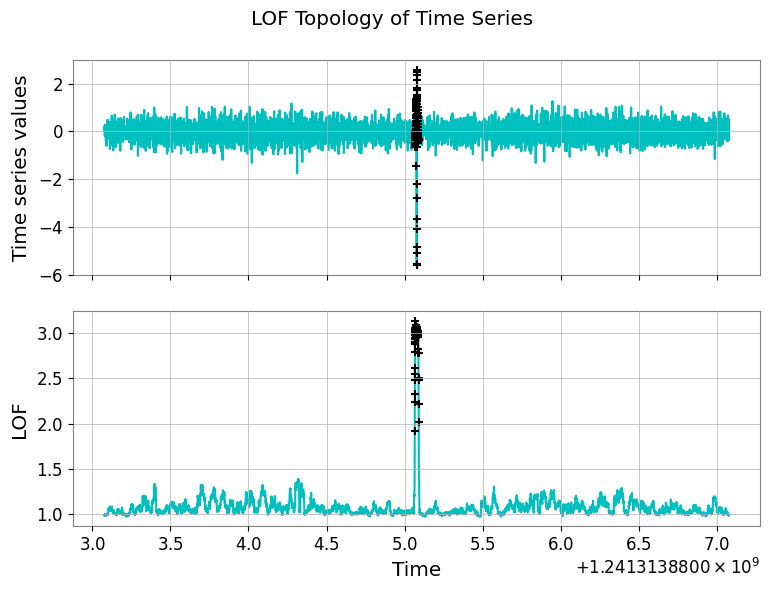

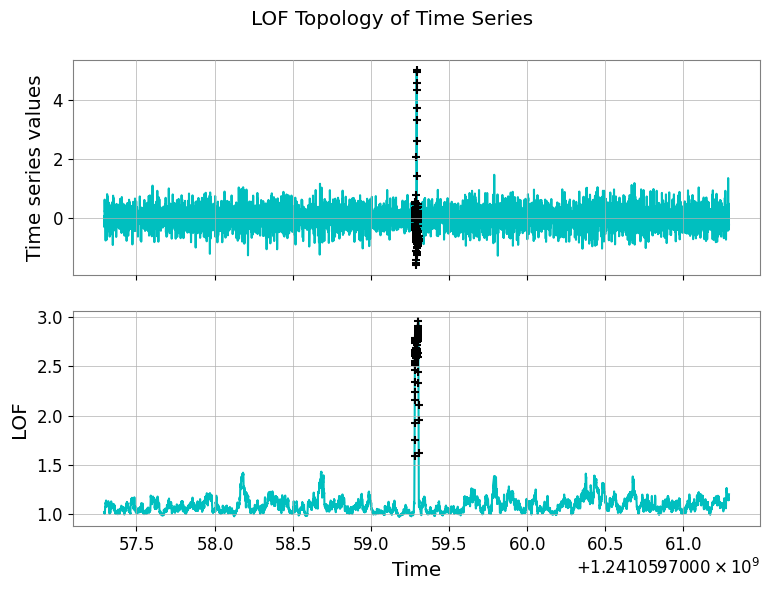

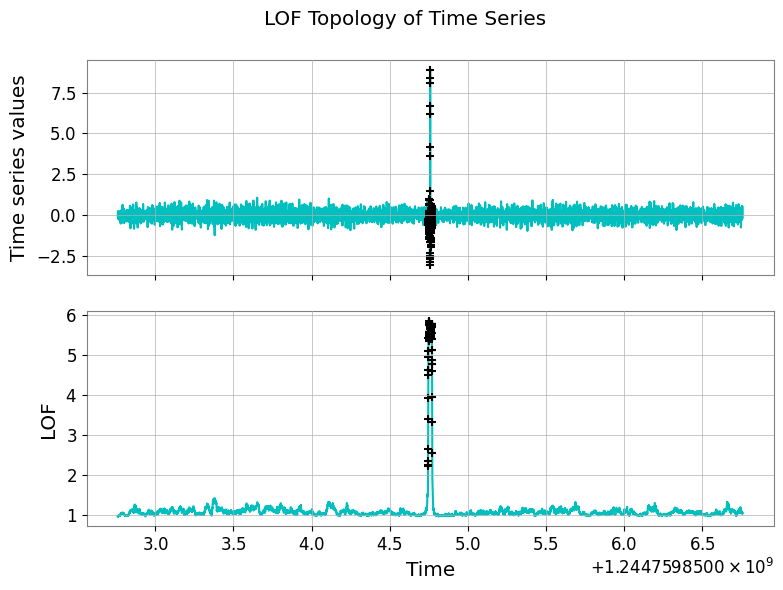

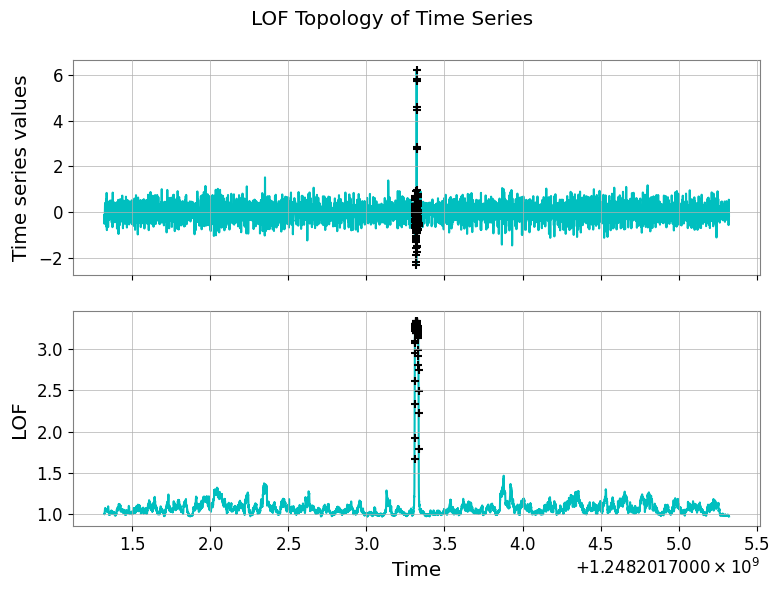

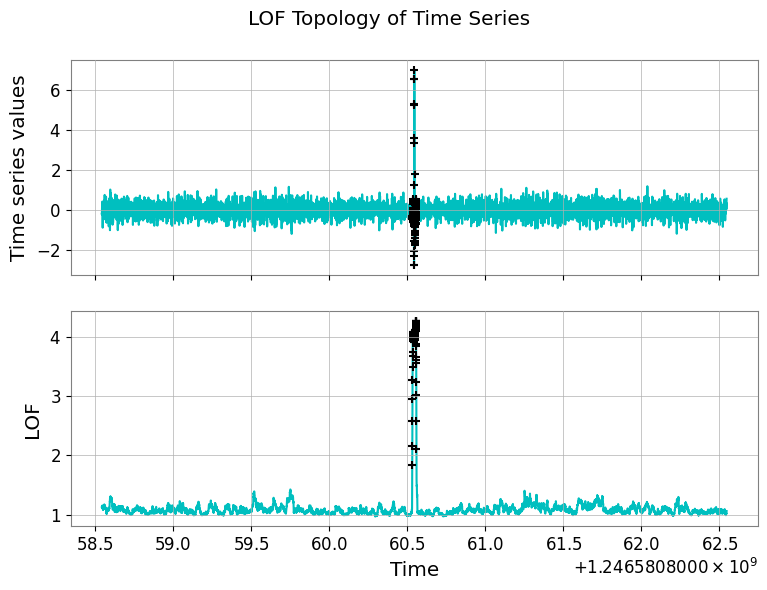

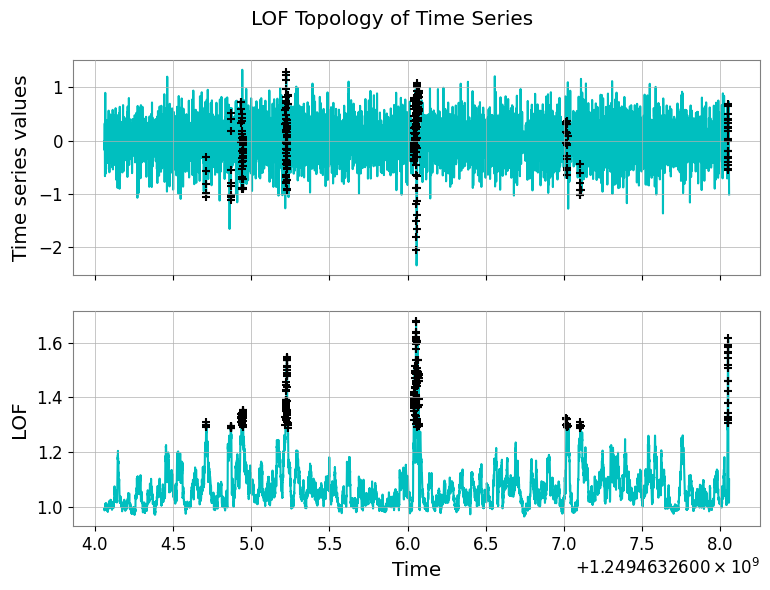

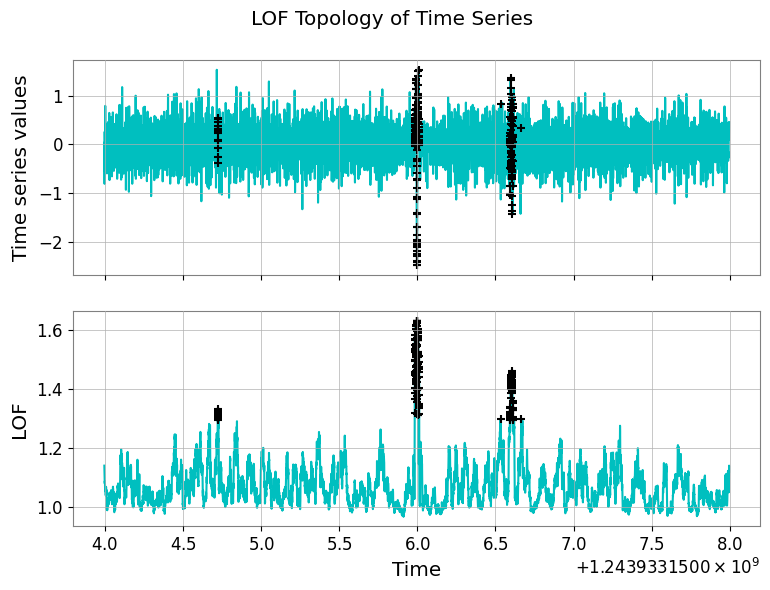

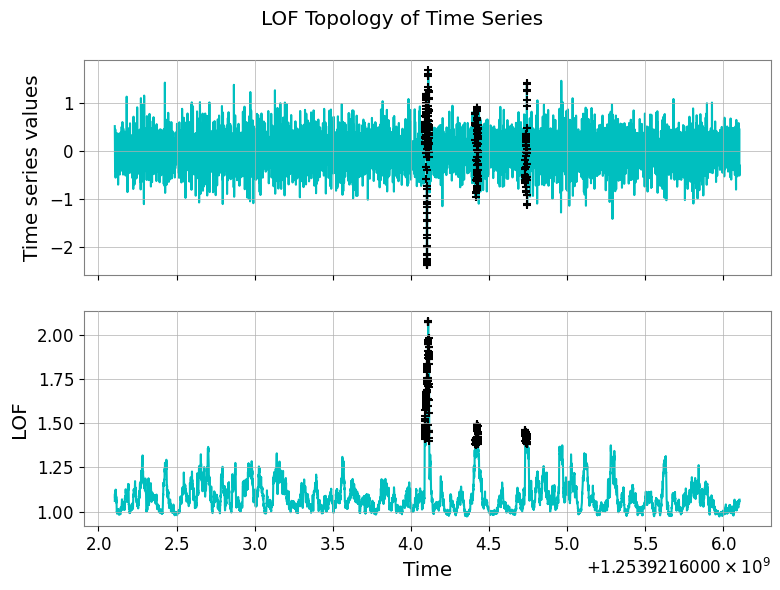

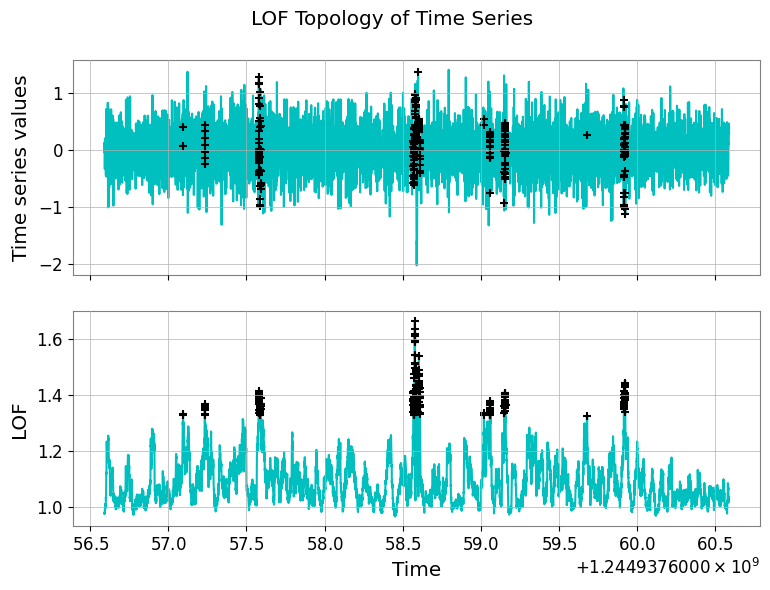

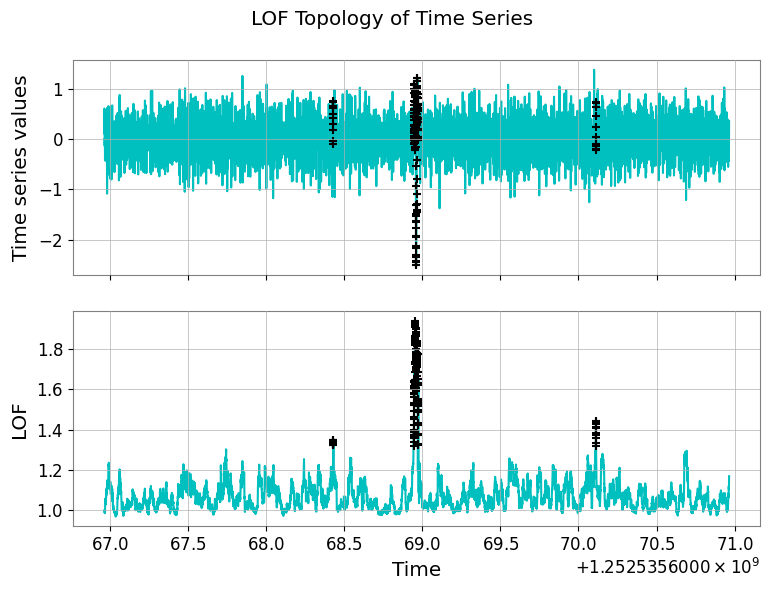

In [94]:
for k, events in enumerate(ALL):
    print('NOW PLOTTING EVENTS OF CLASS', k)
    for i in tqdm(range(len(events))):
        hdata = get_processed_event(DET, events[i], length=4, downsample=1)
        plot_lof_time_series(hdata.times.value, hdata.value, window=100)

In [78]:
## For the whole animation

anim = LOFMaxStdWindowAnimation(
    hdata.value,
    hdata.times.value,
    xlim=(x0,x1),
    n_range=range(5,101,1),
    interval=200
)
plt.close()
anim.show()

  0%|          | 0/96 [00:00<?, ?it/s]